# Finding Period and Initial Best Fit

In [1]:
#Importing and notebook setup
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from gatspy.periodic import LombScargleFast

#for Radvel
import matplotlib
import pylab as pl

import corner

import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

Importing Data

In [2]:
#Data import
data= pd.read_csv('C:/users/rscsa/Research/radvel-master/research/HD75732/HD75732.csv')

data_rk = data[0:23]
data_rj = data[24:653]
#Naming Variables from data
t = np.array(data_rj.jd)
vel = np.array(data_rj.mnvel)
errvel = np.array(data_rj.errvel)

#best fit time vector
ti = np.linspace(t.min(),t.max(),num=len(t)* 10000)
# print data

Define Periodogram Function

In [3]:
def periodogram(datax, datay, min_, max_, nyquist):
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist) # Default 50

    #Plotting
    plt.figure
    plt.plot(period,power)
    plt.ylabel('Power')
    plt.xlabel('Period')# days
    plt.xscale('log')
#     plt.xlim(min_-1,max_+10)

    # set range and find period (Correct)
    model.optimizer.period_range=(min_, max_)
    period = model.best_period
    print("period = {0}".format(period))
    return period

Function for RadVel and Residuals

Define RMS Function

In [4]:
def RMS (Residuals):
    RMS = np.sqrt(sum(Residuals**2 / (len(Residuals))))
    return RMS

Function to find Residuals

In [5]:
def residuals(data_x, data_y,amplitude,period,phase_shift,vertical_shift):
    # Target function
    fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x
    #Distance to the target function
    errfunc = lambda p, x, y: fitfunc(p, x) - y 
    
    # Initial guess for the first set's parameters
    p0 = [amplitude, period, phase_shift, vertical_shift]
    p1, success = optimize.leastsq(errfunc, p0[:], args=(data_x, data_y))
    
    print 'Amplitude: ', p1[0]
    print 'Period: ', p1[1]
    print 'Phase Shift: ', p1[2]
    print 'Vertical-Shift: ',p1[3]
    period = p1[1]
    
    #Finding Residuals
    Residuals = data_y - fitfunc(p1,data_x)
    #Finding RMS
    RMS = np.sqrt(sum(Residuals**2 / (len(Residuals))))
    #chisquared
    #chisquared = sum(Residuals**2/(fitfunc(p1,data_x)))
    print "RMS of Residuals: ", RMS
    #print "Chi-Squared for Residuals: ", chisquared
    
    #Plotting Data with Fit
    time = np.linspace(data_x.min(), data_x.max(), 1000*len(data_x))
    plt.plot(data_x, data_y, "go", time, fitfunc(p1, time),"b-")
    plt.title('HD217014')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Data', 'Fit'))
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    ax1 = plt.axes()
    plt.show()
    
    #plotting Residuals
    #plt.plot(data_x, Residuals, "ro", time, fitfunc(p2, time),"b-")
    plt.plot(data_x, Residuals, "ro")
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    plt.ylim(-max(data_y)-10, max(data_y)+10)
    plt.title('Residuals')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Residuals', 'Fit'))
    ax2 = plt.axes()
    
    return Residuals, period

Define a simple plotting function to display the data, model, and residuals

In [6]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

# Finding Period in Data (1st Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 14.6521574048


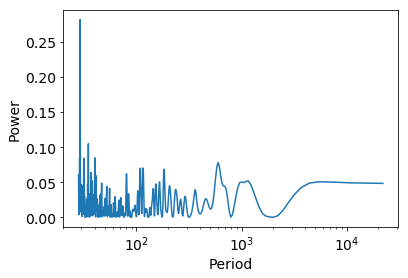

In [7]:
nyquist = .5
period1 = periodogram(t,vel,1,max(t)-min(t),nyquist)

Initializing Radvel

In [8]:
nplanets = 1
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = period1    # period of 1st planet
    params['tc1'] = 2074.52   # time of inferior conjunction of 1st planet
    params['secosw1'] = 0.01 
    params['sesinw1'] =  0.01 
    params['logk1'] =  np.log(50)   # velocity semi-amplitude for 1st planet  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

In [9]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6
# like.params['gamma_k'] = 0.0
# like.params['gamma_j'] = 1.0
# like.params['jit_k'] = 2.6
# like.params['jit_j'] = 2.6

Defining Variables that are going to vary.

In [10]:
like.vary['curv'] = True
like.vary['dvdt'] = True
#like.vary['per1'] = False
#like.vary['logk1'] = False
#like.vary['secosw1'] = False
#like.vary['sesinw1'] = False
#like.vary['tc1'] = False


Plotting Radvels Initial Likelihood

C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


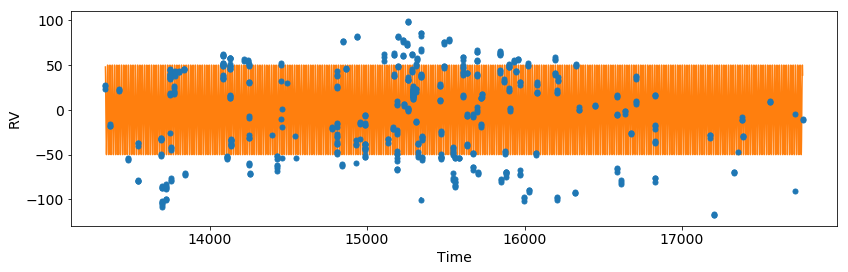

In [11]:
pl.figure()
plot_results(like)
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

Maximize the likelihood and print the updated posterior object

In [12]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_k', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_j', np.log(1), np.log(15))]

print post

parameter                     value      vary
curv                              0       True
dvdt                              0       True
gamma                             1       True
jit                             2.6       True
logk1                       3.91202       True
per1                        14.6522       True
secosw1                        0.01       True
sesinw1                        0.01       True
tc1                         2074.52       True

Priors
------
Gaussian prior on per1, mu=14.6521574048, sigma=3.66303935119
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



parameter                     value      vary
curv                   -8.26101e-08       True
dvdt                    0.000125423       True
gamma                       3.80989       True
jit                         21.2012       True
logk1                       4.17173       True
per1                        14.6522       True
secosw1                   0.0299416       True
sesinw1                   -0.121018       True
tc1                         2074.16       True

Priors
------
Gaussian prior on per1, mu=14.6521574048, sigma=3.66303935119
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(<matplotlib.figure.Figure at 0xdc5d2b0>,
  <matplotlib.axes._subplots.AxesSubplot at 0xf4f5128>])

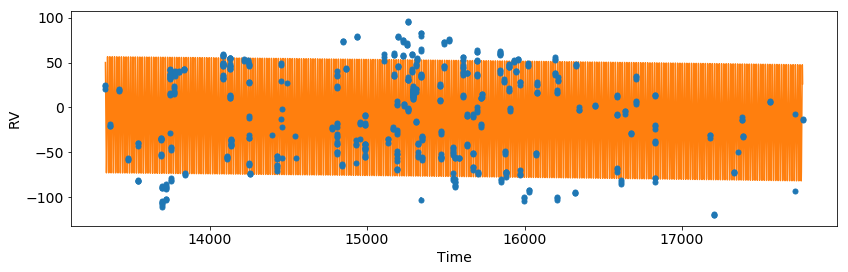

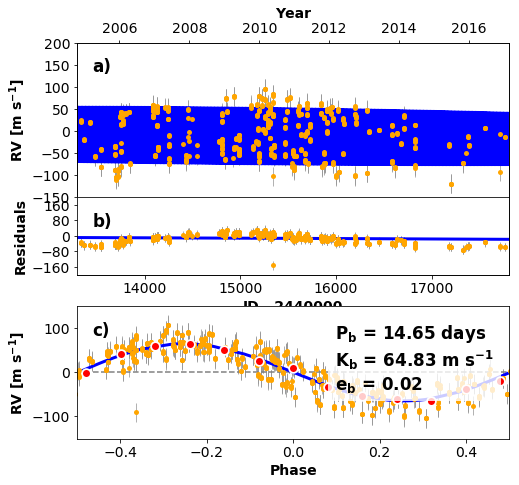

In [13]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )
#Get residuals
#orbel = []
#radvel.kepler.rv_drive(t)
plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [14]:
Residuals_Radvel_1 = post.likelihood.residuals()
RMS_Radvel_1 = RMS(Residuals_Radvel_1)
print 'Radvel RMS of Residuals: ', RMS_Radvel_1

Radvel RMS of Residuals:  22.2145645615


# Initial Best Fit My Own Way (1st Planet)

Amplitude:  64.801436309
Period:  14.6530055197
Phase Shift:  -1.59442142435
Vertical-Shift:  -0.000536193798557
RMS of Residuals:  22.355640544


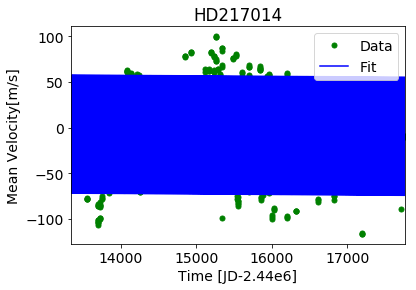

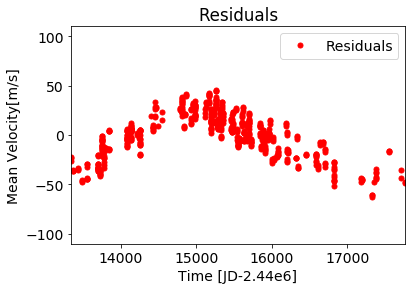

In [15]:
residuals1, period1 = residuals(t,vel,50,period1,0,0)

# Finding Period for 2nd Planet

Looking at Residuals for another Period

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 3706.75039363


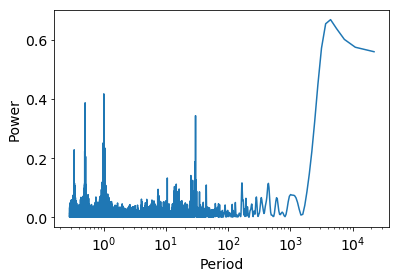

In [16]:
period_radvel_2 = periodogram(t,Residuals_Radvel_1,1,max(t)-min(t),50)

In [17]:
nplanets = 2
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = period_radvel_2 
    params['tc2'] =  4268.95 + 1000   
    params['secosw2'] = 0.01  
    params['sesinw2'] = 0.01 
    params['logk2'] = np.log(RMS_Radvel_1)   
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

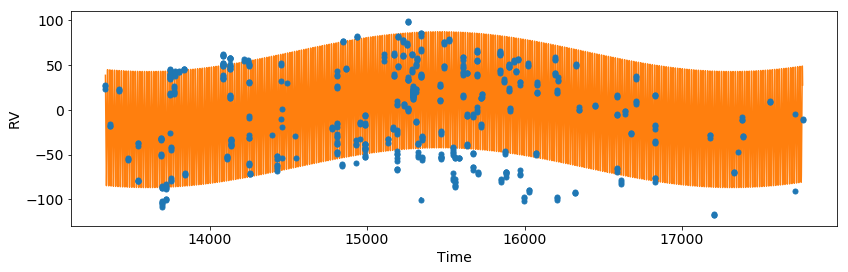

In [18]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [19]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
curv                              0       True
dvdt                              0       True
gamma                             1       True
jit                             2.6       True
logk1                       4.17173       True
logk2                       3.10075       True
per1                        14.6522       True
per2                        3706.75       True
secosw1                   0.0299416       True
secosw2                        0.01       True
sesinw1                   -0.121018       True
sesinw2                        0.01       True
tc1                         2074.16       True
tc2                         5268.95       True

Priors
------
Gaussian prior on per1, mu=14.6522026766, sigma=3.66305066915
Gaussian prior on per2, mu=3706.75039363, sigma=926.687598409
e1 constrained to be < 0.99
e2 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1881: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


parameter                     value      vary
curv                     -1.709e-07       True
dvdt                    0.000505016       True
gamma                       7.57205       True
jit                         11.2612       True
logk1                       4.25216       True
logk2                       3.40466       True
per1                        14.6521       True
per2                        3827.93       True
secosw1                    0.054986       True
secosw2                    0.126428       True
sesinw1                    0.126249       True
sesinw2                   -0.440302       True
tc1                         2074.24       True
tc2                         4455.46       True

Priors
------
Gaussian prior on per1, mu=14.6522026766, sigma=3.66305066915
Gaussian prior on per2, mu=3706.75039363, sigma=926.687598409
e1 constrained to be < 0.99
e2 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



(<matplotlib.figure.Figure at 0xcea27b8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1da57dd8>])

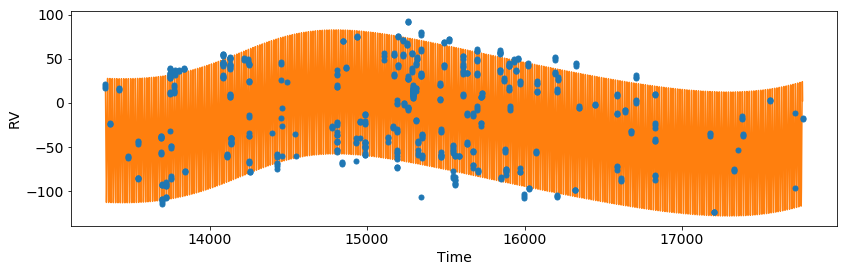

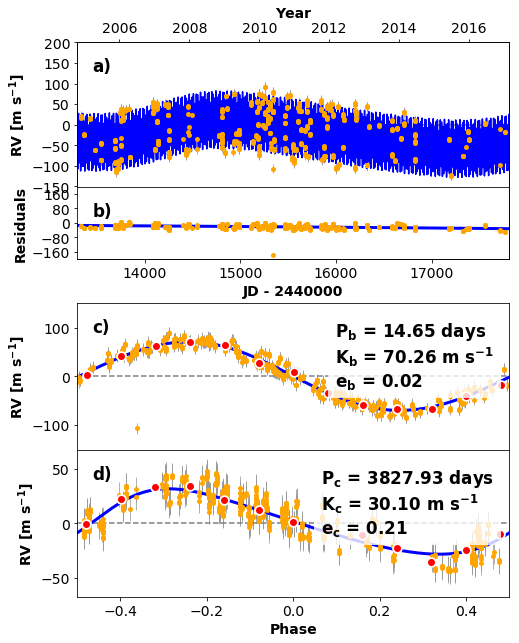

In [20]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [21]:
Residuals_Radvel_2 = post.likelihood.residuals()
RMS_Radvel_2 = RMS(Residuals_Radvel_2)
print 'Radvel RMS of Residuals: ', RMS_Radvel_2

Radvel RMS of Residuals:  11.6623930789


# Initial Best Fit My Own Way (2nd Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 3909.77029152


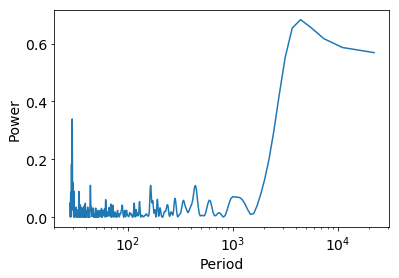

In [22]:
period2 = periodogram(t,residuals1,1,max(t)-min(t),nyquist)

Amplitude:  -30.6992847255
Period:  4264.07029551
Phase Shift:  -0.132410415011
Vertical-Shift:  -0.000657741147824
RMS of Residuals:  12.6266025538


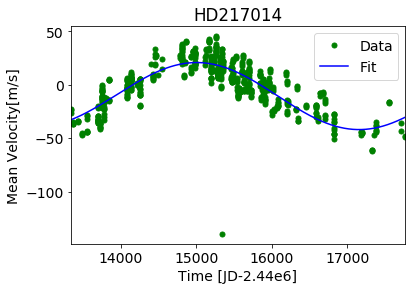

4264.07029551


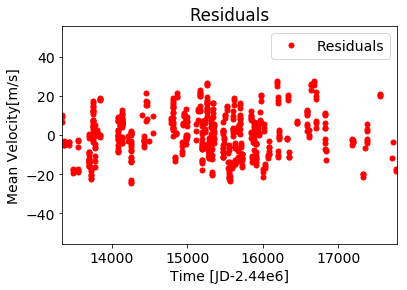

In [23]:
residuals2, period2 = residuals(t,residuals1,50,max(t)-min(t),0,0)
print period2

# Finding Period for Planet 3

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.3873229365


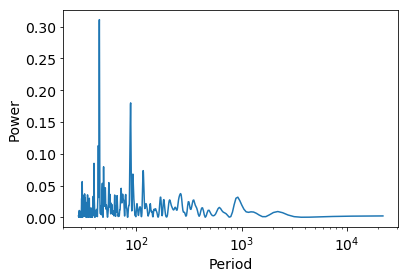

In [24]:
period_radvel_3 = periodogram(t,Residuals_Radvel_2,1,max(t)-min(t),nyquist)

In [25]:
nplanets = 3
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2'] 

    #3rd Planet
    params['per3'] = period_radvel_3
    params['tc3'] = 2087.07 
    params['secosw3'] = 0.01
    params['sesinw3'] =  0.01 
    params['logk3'] = np.log(RMS_Radvel_2)
    
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

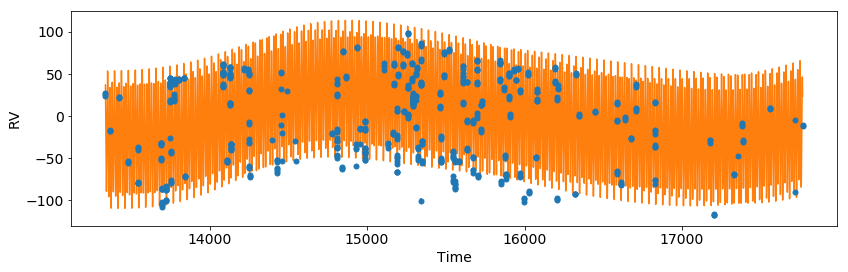

In [26]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [27]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
curv                              0       True
dvdt                              0       True
gamma                             1       True
jit                             2.6       True
logk1                       4.25216       True
logk2                       3.40466       True
logk3                       2.45637       True
per1                        14.6521       True
per2                        3827.93       True
per3                        44.3873       True
secosw1                    0.054986       True
secosw2                    0.126428       True
secosw3                        0.01       True
sesinw1                    0.126249       True
sesinw2                   -0.440302       True
sesinw3                        0.01       True
tc1                         2074.24       True
tc2                         4455.46       True
tc3                         2087.07       True

Priors
------
Gaussian prior on per1, mu=14.6520857228, sigm

parameter                     value      vary
curv                    -9.0088e-08       True
dvdt                   -2.26905e-05       True
gamma                      0.946587       True
jit                         8.78456       True
logk1                       4.25658       True
logk2                       3.43087       True
logk3                       2.40291       True
per1                        14.6521       True
per2                        3835.96       True
per3                        44.3875       True
secosw1                   0.0687146       True
secosw2                   0.0405492       True
secosw3                    0.534411       True
sesinw1                    0.125619       True
sesinw2                   -0.436302       True
sesinw3                    0.281407       True
tc1                         2074.26       True
tc2                         4461.53       True
tc3                         2083.21       True

Priors
------
Gaussian prior on per1, mu=14.6520857228, sigm

(<matplotlib.figure.Figure at 0xd851f28>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1dafef98>])

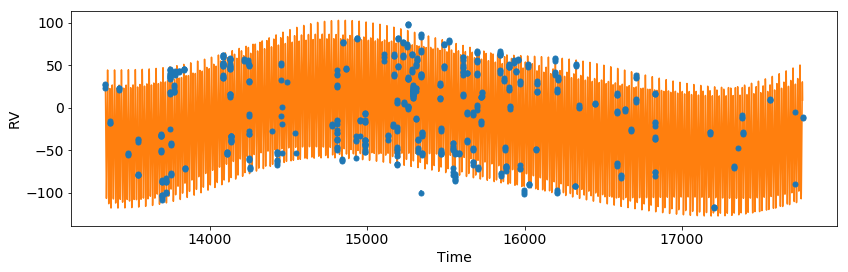

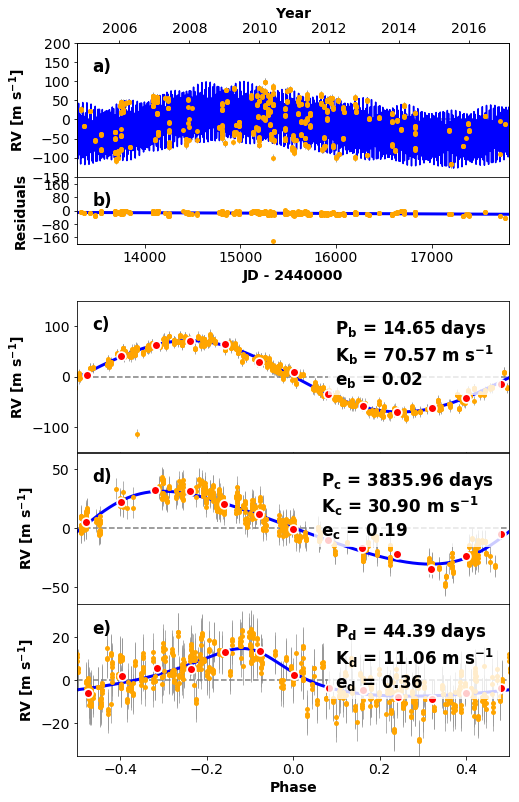

In [28]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [29]:
Residuals_Radvel_3 = post.likelihood.residuals()
RMS_Radvel_3 = RMS(Residuals_Radvel_3)
print 'Radvel RMS of Residuals: ', RMS_Radvel_3

Radvel RMS of Residuals:  9.31956603962


# Initial Best Fit My Own Way (3rd Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.3882132828


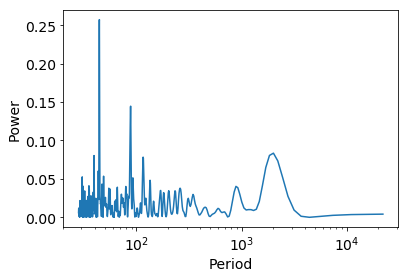

In [30]:
period3 = periodogram(t,residuals2,1,max(t)-min(t),nyquist)

Amplitude:  8.98576746696
Period:  44.3961079755
Phase Shift:  1.84900923807
Vertical-Shift:  2.02645913218e-05
RMS of Residuals:  10.882096507


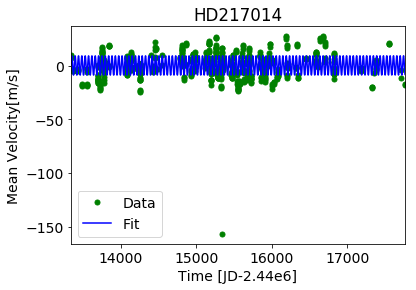

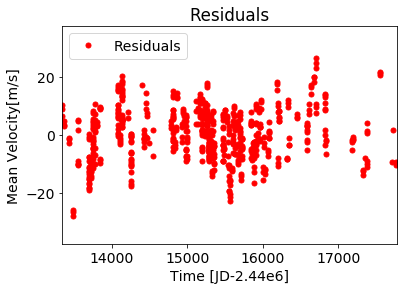

In [31]:
residuals3, period3 = residuals(t,residuals2,40,period3,0,0)

# Finding 4th Planet

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.8173896689


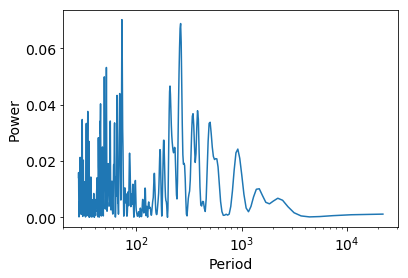

In [32]:
period_radvel_4 = periodogram(t,Residuals_Radvel_3,1,max(t)-min(t),nyquist)

In [33]:
nplanets = 4
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = period_radvel_4
    params['tc4'] = 2087.07 -1000   
    params['secosw4'] = 0.01
    params['sesinw4'] = 0.01
    params['logk4'] = np.log(RMS_Radvel_3)   
 
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

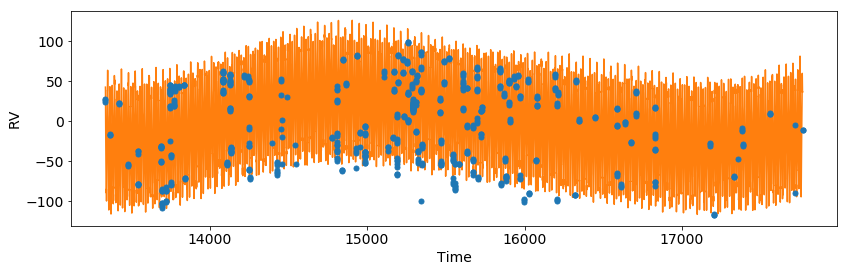

In [34]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [35]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
curv                              0       True
dvdt                              0       True
gamma                             1       True
jit                             2.6       True
logk1                       4.25658       True
logk2                       3.43087       True
logk3                       2.40291       True
logk4                       2.23212       True
per1                        14.6521       True
per2                        3835.96       True
per3                        44.3875       True
per4                        2.81739       True
secosw1                   0.0687146       True
secosw2                   0.0405492       True
secosw3                    0.534411       True
secosw4                        0.01       True
sesinw1                    0.125619       True
sesinw2                   -0.436302       True
sesinw3                    0.281407       True
sesinw4                        0.01       True
tc1           

parameter                     value      vary
curv                   -9.16743e-08       True
dvdt                    1.90483e-06       True
gamma                      0.828926       True
jit                         7.85125       True
logk1                       4.25418       True
logk2                       3.45454       True
logk3                       2.37233       True
logk4                       1.71349       True
per1                        14.6521       True
per2                        3845.71       True
per3                        44.3882       True
per4                        2.81739       True
secosw1                 -0.00571568       True
secosw2                   0.0397695       True
secosw3                     0.42018       True
secosw4                   -0.164819       True
sesinw1                    0.117911       True
sesinw2                   -0.436403       True
sesinw3                    0.412947       True
sesinw4                  -0.0708831       True
tc1           

(<matplotlib.figure.Figure at 0x249ea780>,
  <matplotlib.axes._subplots.AxesSubplot at 0x251f5128>])

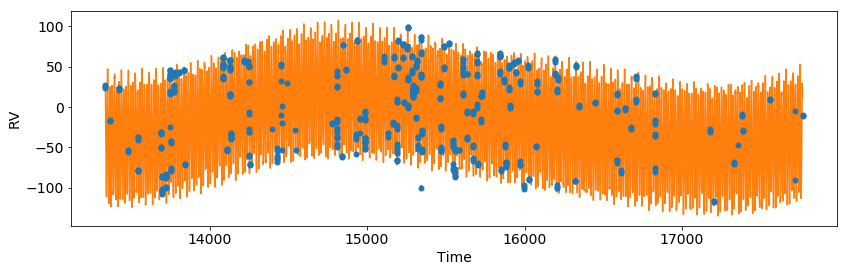

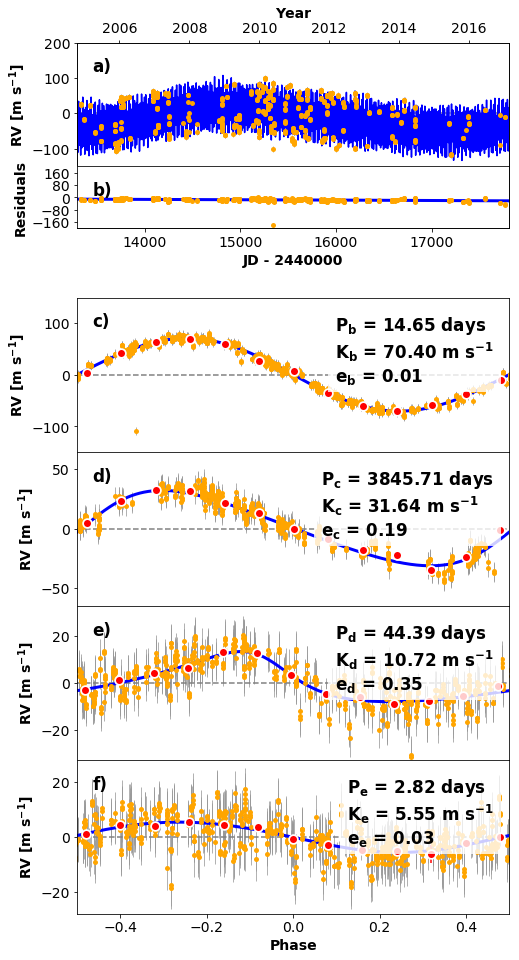

In [36]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [37]:
Residuals_Radvel_4 = post.likelihood.residuals()
RMS_Radvel_4 = RMS(Residuals_Radvel_4)
print 'Radvel RMS of Residuals: ', RMS_Radvel_4

Radvel RMS of Residuals:  8.47127944645


# Initial Best Fit My Own Way (4th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.81733586558


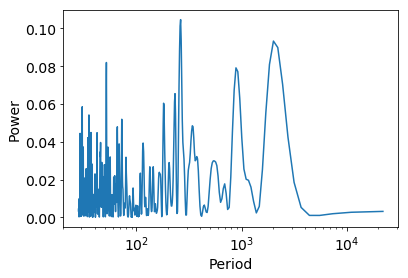

In [38]:
period4 = periodogram(t,residuals3,1,max(t)-min(t),nyquist)

Amplitude:  -5.57466347825
Period:  2.81734490085
Phase Shift:  -0.215815440086
Vertical-Shift:  1.20485929111e-05
RMS of Residuals:  10.1222972334


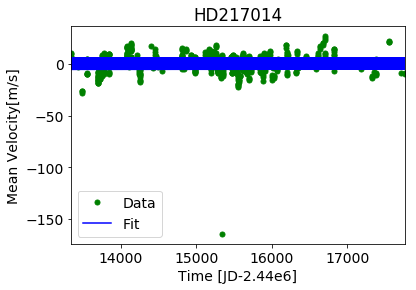

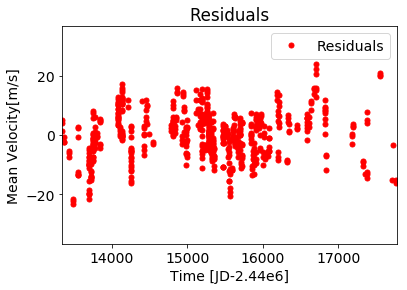

In [39]:
residuals4, period4 = residuals(t,residuals3,20,period4,0,0)

# 5th Planet Period

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1.2 to 4.4e+03
 - Computing periods at 18438 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 264.799567429


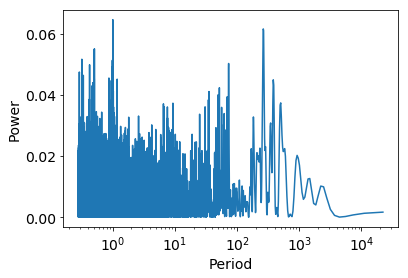

In [40]:
period_radvel_5 = periodogram(t,Residuals_Radvel_4,1.2,max(t)-min(t),50)
period_radvel_5 = 259.7

In [41]:
nplanets = 5
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = post.params['per4']
    params['tc4'] = post.params['tc4']
    params['secosw4'] = post.params['secosw4']
    params['sesinw4'] = post.params['sesinw4']
    params['logk4'] = post.params['logk4']
    
    #5th Planet
    params['per5'] = period_radvel_5
    params['tc5'] = 2087.07  
    params['secosw5'] = 0.01
    params['sesinw5'] = 0.01
    params['logk5'] = np.log(RMS_Radvel_4)  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

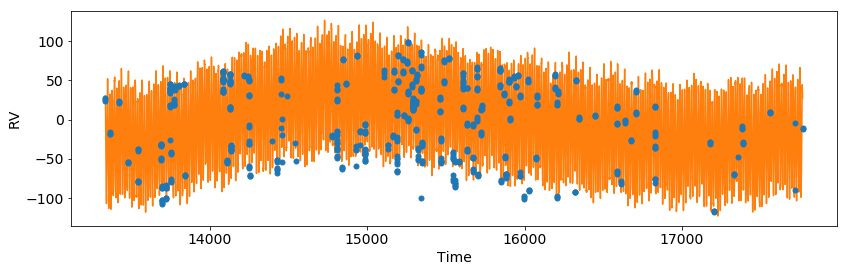

In [42]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [43]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
post.priors += [radvel.prior.Gaussian('per5',like.params['per5'],.25*like.params['per5'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
curv                              0       True
dvdt                              0       True
gamma                             1       True
jit                             2.6       True
logk1                       4.25418       True
logk2                       3.45454       True
logk3                       2.37233       True
logk4                       1.71349       True
logk5                       2.13668       True
per1                        14.6521       True
per2                        3845.71       True
per3                        44.3882       True
per4                        2.81739       True
per5                          259.7       True
secosw1                 -0.00571568       True
secosw2                   0.0397695       True
secosw3                     0.42018       True
secosw4                   -0.164819       True
secosw5                        0.01       True
sesinw1                    0.117911       True
sesinw2       

C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1877: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


parameter                     value      vary
curv                   -9.57252e-08       True
dvdt                    3.82108e-05       True
gamma                       1.02395       True
jit                         7.83348       True
logk1                       4.25412       True
logk2                       3.45458       True
logk3                       2.37277       True
logk4                       1.71807       True
logk5                      -65.1823       True
per1                        14.6521       True
per2                        3847.22       True
per3                        44.3886       True
per4                        2.81739       True
per5                          259.7       True
secosw1                  0.00829564       True
secosw2                   0.0382961       True
secosw3                    0.420838       True
secosw4                    -0.14559       True
secosw5                   -0.614878       True
sesinw1                    0.116801       True
sesinw2       

(<matplotlib.figure.Figure at 0x119c0f60>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11605048>])

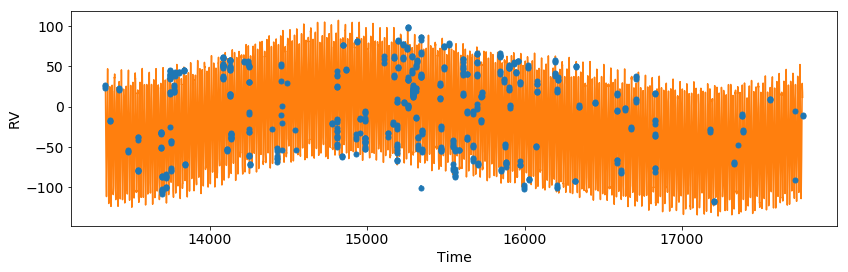

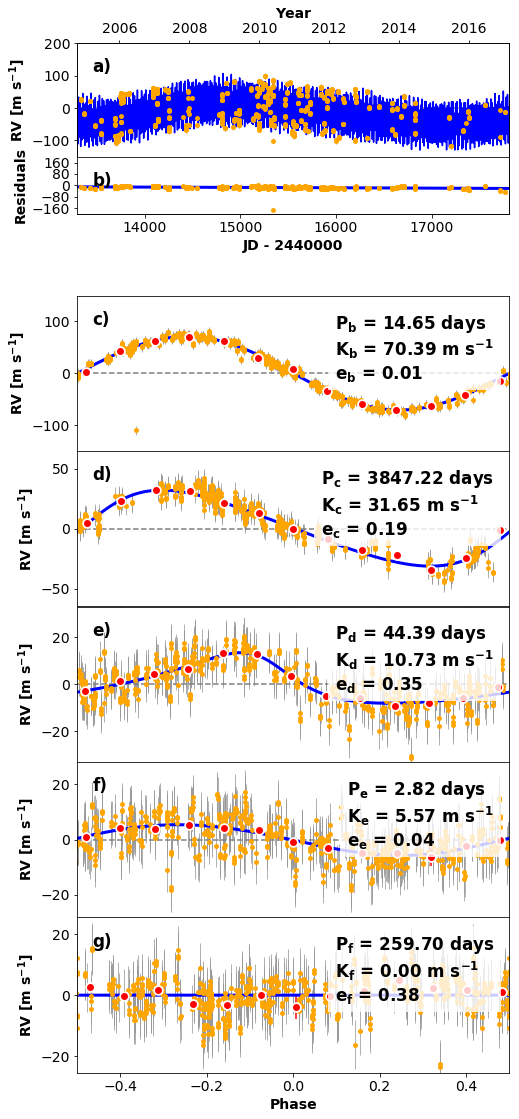

In [44]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [45]:
Residuals_Radvel_5 = post.likelihood.residuals()
RMS_Radvel_5 = RMS(Residuals_Radvel_5)
print 'Radvel RMS of Residuals: ', RMS_Radvel_5

Radvel RMS of Residuals:  8.4690335534


# Initial Best Fit My Own Way (5th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  15 to 1.5e+03
 - Computing periods at 1462 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 263.090544328


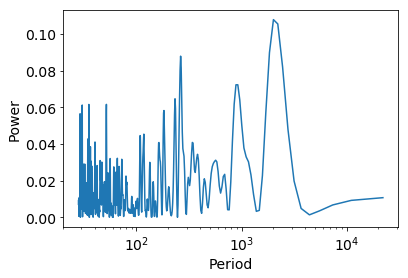

In [46]:
period5 = periodogram(t,residuals4,15,1500,nyquist)

Amplitude:  -4.0651144166
Period:  263.688835104
Phase Shift:  -0.251462282468
Vertical-Shift:  2.66415028591e-05
RMS of Residuals:  9.66468826502


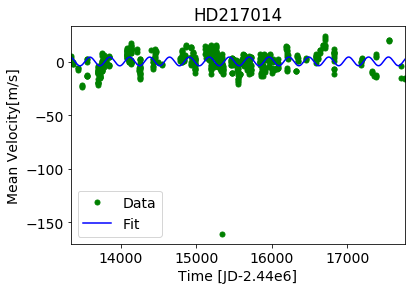

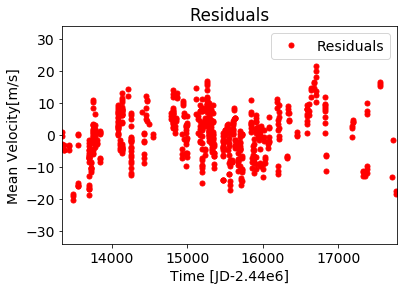

In [47]:
residuals5, period5 = residuals(t,residuals4,20,period5,0,0)

In [48]:
print "Radvel Results for Periods: "
print "Period1 Radvel: ", period1
print "Period1 My Guess: ", period1
print ''

print "Period2 Radvel: ", period_radvel_2
print "Period2 My Guess: ", period2
print ''

print "Period3 Radvel: ", period_radvel_3
print "Period3 My Guess: ", period3
print ''

print "Period4 Radvel: ", period_radvel_4
print "Period4 My Guess: ", period4
print ''

print "Period5 Radvel: ", period_radvel_5
print "Period5 My Guess: ", period5

Radvel Results for Periods: 
Period1 Radvel:  14.6530055197
Period1 My Guess:  14.6530055197

Period2 Radvel:  3706.75039363
Period2 My Guess:  4264.07029551

Period3 Radvel:  44.3873229365
Period3 My Guess:  44.3961079755

Period4 Radvel:  2.8173896689
Period4 My Guess:  2.81734490085

Period5 Radvel:  259.7
Period5 My Guess:  263.688835104


# Possible 6th Planet

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1.2 to 2e+02
 - Computing periods at 18332 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 72.9529743526


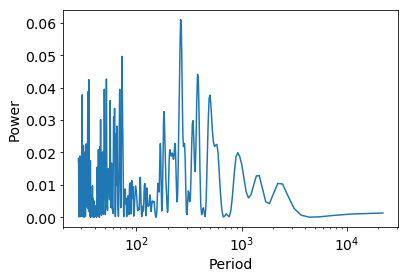

In [49]:
period_radvel_6 = periodogram(t,Residuals_Radvel_5,1.2,200,nyquist)

In [50]:
nplanets = 6
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = post.params['per4']
    params['tc4'] = post.params['tc4']
    params['secosw4'] = post.params['secosw4']
    params['sesinw4'] = post.params['sesinw4']
    params['logk4'] = post.params['logk4']
    
    #5th Planet
    params['per5'] = post.params['per5']
    params['tc5'] = post.params['tc5']
    params['secosw5'] = post.params['secosw5']
    params['sesinw5'] = post.params['sesinw5']
    params['logk5'] = post.params['logk5'] 
    
    #6th Planet
    params['per6'] = period_radvel_6
    params['tc6'] = 2087.07  
    params['secosw6'] = 0.01
    params['sesinw6'] = 0.01
    params['logk6'] = np.log(RMS_Radvel_5) 

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

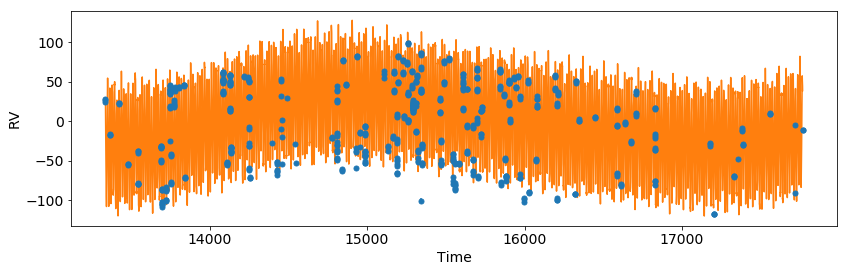

In [51]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [52]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
post.priors += [radvel.prior.Gaussian('per5',like.params['per5'],.25*like.params['per5'])]
post.priors += [radvel.prior.Gaussian('per6',like.params['per6'],.25*like.params['per6'])]


post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
curv                              0       True
dvdt                              0       True
gamma                             1       True
jit                             2.6       True
logk1                       4.25412       True
logk2                       3.45458       True
logk3                       2.37277       True
logk4                       1.71807       True
logk5                      -65.1823       True
logk6                       2.13642       True
per1                        14.6521       True
per2                        3847.22       True
per3                        44.3886       True
per4                        2.81739       True
per5                          259.7       True
per6                         72.953       True
secosw1                  0.00829564       True
secosw2                   0.0382961       True
secosw3                    0.420838       True
secosw4                    -0.14559       True
secosw5       

parameter                     value      vary
curv                   -9.29959e-08       True
dvdt                    5.17061e-06       True
gamma                      0.974353       True
jit                          7.8321       True
logk1                       4.25396       True
logk2                       3.45472       True
logk3                       2.37349       True
logk4                       1.71648       True
logk5                      -57.4185       True
logk6                      -65.1826       True
per1                        14.6521       True
per2                        3849.14       True
per3                        44.3887       True
per4                        2.81739       True
per5                          259.7       True
per6                         72.953       True
secosw1                  0.00877477       True
secosw2                   0.0355257       True
secosw3                    0.425186       True
secosw4                    -0.12547       True
secosw5       

(<matplotlib.figure.Figure at 0x16cd1f28>,
  <matplotlib.axes._subplots.AxesSubplot at 0x17af7eb8>])

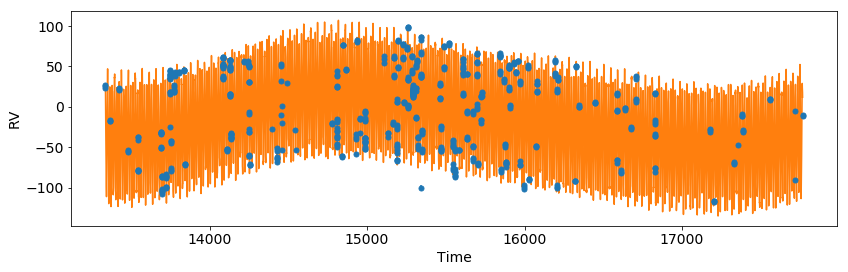

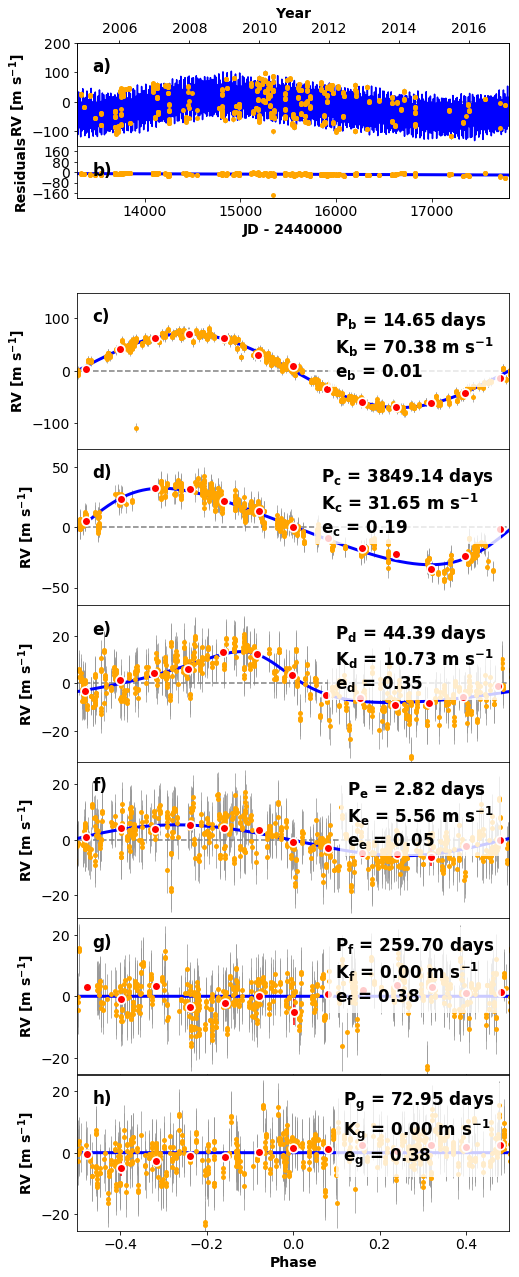

In [53]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [54]:
Residuals_Radvel_5 = post.likelihood.residuals()
RMS_Radvel_5 = RMS(Residuals_Radvel_5)
print 'Radvel RMS of Residuals: ', RMS_Radvel_5

Radvel RMS of Residuals:  8.46726642514


# Initial Best Fit My Own Way (6th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  15 to 1e+03
 - Computing periods at 1455 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 117.659412108


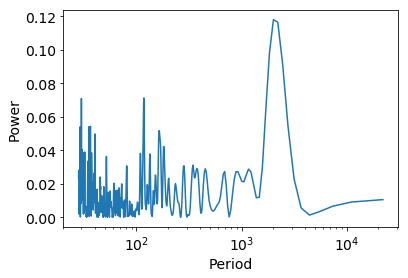

In [55]:
period6 = periodogram(t,residuals5,15,1000,nyquist)

Amplitude:  1.21102843377
Period:  2.81504454237
Phase Shift:  -27.0116425579
Vertical-Shift:  -2.49854893143e-06
RMS of Residuals:  9.62787956605


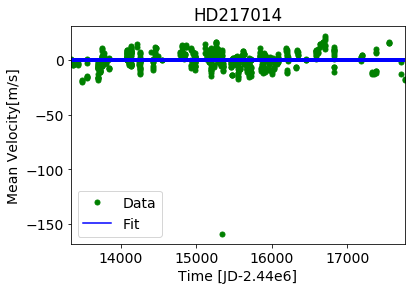

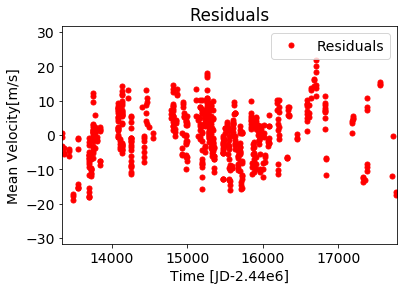

In [56]:
residuals6, period6 = residuals(t,residuals5,20,period4,0,0)

# Utilizing RadVel Module

Define a function that we will use to initialize the ``radvel.RVParameters`` and ``radvel.RVModel`` objects

curv                   -7.39154e-08       True
dvdt                   -0.000573222       True
gamma                       4.61095       True
jit                         11.2417       True
logk1                       4.24819       True
logk2                       3.42597       True
per1                        14.6521       True
per2                        3901.48       True
secosw1                   0.0647091       True
secosw2                   0.0836947       True
sesinw1                     0.10735       True
sesinw2                   -0.419884       True
tc1                         2074.21       True
tc2                         4268.95       True

# MCMC Chain

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties.

In [57]:
# df = radvel.mcmc(post,nwalkers=50,nrun=5000)

Now lets make a corner plot to display the posterior distributions.

In [58]:
# radvel.plotting.corner_plot(post, df)

In [59]:
# print post
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [60]:
"""
df['k1'] = np.exp(df['logk1'])
df['k2'] = np.exp(df['logk2'])
df['k3'] = np.exp(df['logk3'])
df['k4'] = np.exp(df['logk4'])
df['jit'] = np.exp(df['jit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2
df['e3'] = df['secosw3']**2 + df['sesinw3']**2
df['e4'] = df['secosw4']**2 + df['sesinw4']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])

df['ecosw3'] = df['secosw3']*np.sqrt(df['e3'])
df['esinw3'] = df['sesinw3']*np.sqrt(df['e3'])

df['ecosw4'] = df['secosw4']*np.sqrt(df['e4'])
df['esinw4'] = df['sesinw4']*np.sqrt(df['e4'])

labels = 'k1 k2 k3 k4 jit e1 e2 e3 e4'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84,]
    )
"""

"\ndf['k1'] = np.exp(df['logk1'])\ndf['k2'] = np.exp(df['logk2'])\ndf['k3'] = np.exp(df['logk3'])\ndf['k4'] = np.exp(df['logk4'])\ndf['jit'] = np.exp(df['jit'])\ndf['e1'] = df['secosw1']**2 + df['sesinw1']**2\ndf['e2'] = df['secosw2']**2 + df['sesinw2']**2\ndf['e3'] = df['secosw3']**2 + df['sesinw3']**2\ndf['e4'] = df['secosw4']**2 + df['sesinw4']**2\n\ndf['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])\ndf['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])\n\ndf['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])\ndf['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])\n\ndf['ecosw3'] = df['secosw3']*np.sqrt(df['e3'])\ndf['esinw3'] = df['sesinw3']*np.sqrt(df['e3'])\n\ndf['ecosw4'] = df['secosw4']*np.sqrt(df['e4'])\ndf['esinw4'] = df['sesinw4']*np.sqrt(df['e4'])\n\nlabels = 'k1 k2 k3 k4 jit e1 e2 e3 e4'.split()\nfig = corner.corner(\n    df[labels],\n    labels=labels,\n    levels=[0.68,0.95],\n    plot_datapoints=False,\n    smooth=True,\n    bins=20,\n    quantiles=[.14,.5,.84,]\n    )\n"

In [61]:
# print post
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)